# Compute metrics code

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rapidfuzz.distance.Levenshtein import distance as levenshtein
from sklearn.metrics import r2_score

In [3]:
def sigmoid(x):
    return 2 - 2 / (1 + np.exp(-x))


def normalized_rmse(y_true, y_pred):
    # The argument to the sigmoid transform is equal to 
    # rmse(y_true, y_pred) / rmse(y_true, np.mean(y_true))
    return sigmoid((1 - r2_score(y_true, y_pred)) ** 0.5)


def normalized_levenshtein_score(y_true, y_pred):
    total_distance = np.sum([levenshtein(yt, yp) for yt, yp in zip(y_true, y_pred)])
    length_sum = np.sum([len(yt) for yt in y_true])
    return sigmoid(total_distance / length_sum)


def score_series(y_true, y_pred):
    if len(y_true) != len(y_pred):
        return 0.0
    if isinstance(y_true[0], str):
        return normalized_levenshtein_score(y_true, y_pred)
    else:
        return normalized_rmse(y_true, y_pred)


def benetech_score(ground_truth: pd.DataFrame, predictions: pd.DataFrame) -> float:
    """Evaluate predictions using the metric from the Benetech - Making Graphs Accessible.
    
    Parameters
    ----------
    ground_truth: pd.DataFrame
        Has columns `[data_series, chart_type]` and an index `id`. Values in `data_series` 
        should be either arrays of floats or arrays of strings.
    
    predictions: pd.DataFrame
    """
    if not ground_truth.index.equals(predictions.index):
        raise ValueError("Must have exactly one prediction for each ground-truth instance.")
    if not ground_truth.columns.equals(predictions.columns):
        raise ValueError(f"Predictions must have columns: {ground_truth.columns}.")
    pairs = zip(ground_truth.itertuples(index=False), predictions.itertuples(index=False))
    scores = []
    for (gt_series, gt_type), (pred_series, pred_type) in pairs:
        if gt_type != pred_type:  # Check chart_type condition
            scores.append(0.0)
        else:  # Score with RMSE or Levenshtein as appropriate
            scores.append(score_series(gt_series, pred_series))
    return np.mean(scores)

### Inference Code

In [4]:
%load_ext autoreload
%autoreload 2

# export environment variables
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
import sys

sys.path.insert(0, "./text_detection/src")
sys.path.append("./classification/src")
sys.path.append("./detection/src")
sys.path.append("./text_recognition/src")

import numpy as np
import pandas as pd
import os

from classification.core import ClassificationModel
from detection.core import ObjectDetectionModel
from text_recognition.core import TextRecognitionModel
from text_detection.core import TextDetectionModel
from postprocessing.core import Postprocessing

/opt/conda/envs/env38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from matplotlib import pyplot as plt
import cv2
import numpy as np


In [7]:
image_folder = "./data/validation/images"
image_paths = [os.path.join(image_folder, x) for x in os.listdir(image_folder) if ".jpg" in x]

In [8]:
graph_classfication_config = {
    "model_name": "resnet50",
    "n_classes": 5,
    "weights_path": "./weights/graph_classification.pth",
}

x_type_classification_config = {
    "model_name": "resnet50",
    "n_classes": 2,
    "weights_path": "./weights/x_type_classification.pth",
}

y_type_classification_config = {
    "model_name": "resnet50",
    "n_classes": 2,
    "weights_path": "./weights/y_type_classification.pth",
}

keypoint_detection_config = {
    "name": "keypoint_detection",
    "experiment_path": "./detection/src/exps/example/custom/bmga.py",
    "weights_path": "./weights/keypoint_detection.pth",
    "classes": ["value", "x", "y"], #, "x_label", "y_label"],
    "conf_thre": 0.15,
    "nms_thre": 0.25,
    "test_size": (640, 640),
}

text_detection_config = {
    "weights_path": "./weights/synthtext_finetune_ic19_res50_dcn_fpn_dbv2",
    # "config_path": "/home/thanh/bmga/text_detection/src/experiments/seg_detector/totaltext_resnet50_deform_thre.yaml",
    "config_path": "/home/thanh/bmga/text_detection/src/experiments/ASF/td500_resnet50_deform_thre_asf.yaml",
    "image_short_side": 768,
    "thresh": 0.1,
    "box_thresh": 0.05,
    "resize": False,
    "polygon": True,
}

x_labels_text_detection_config = {
    "weights_path": "./weights/db_x_labels",
    "config_path": "/home/thanh/bmga/text_detection/src/experiments/ASF/td500_resnet50_deform_thre_asf.yaml",
    "image_short_side": 768,
    "thresh": 0.15,
    "box_thresh": 0.25,
    "resize": False,
    "polygon": True,
}

y_labels_text_detection_config = {
    "weights_path": "./weights/db_y_labels",
    "config_path": "/home/thanh/bmga/text_detection/src/experiments/ASF/td500_resnet50_deform_thre_asf.yaml",
    "image_short_side": 768,
    "thresh": 0.05,
    "box_thresh": 0.25,
    "resize": False,
    "polygon": True,
}

text_recognition_config = {
    "weights_path": "baudm/parseq",
    "model_name": "parseq",
}

graph_classification_model = ClassificationModel(**graph_classfication_config)
x_type_classification_model = ClassificationModel(**x_type_classification_config)
y_type_classification_model = ClassificationModel(**y_type_classification_config)
keypoint_detection_model = ObjectDetectionModel(**keypoint_detection_config)
text_detection_model = TextDetectionModel(**text_detection_config)
x_labels_text_detection_model = TextDetectionModel(**x_labels_text_detection_config)
y_labels_text_detection_model = TextDetectionModel(**y_labels_text_detection_config)
text_recognition_model = TextRecognitionModel(**text_recognition_config)

verbose: True
Initializing log dir for workspace/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss
Resuming from ./weights/synthtext_finetune_ic19_res50_dcn_fpn_dbv2
Resumed from ./weights/synthtext_finetune_ic19_res50_dcn_fpn_dbv2
verbose: True
Initializing log dir for workspace/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss
Resuming from ./weights/db_x_labels
Resumed from ./weights/db_x_labels
verbose: True
Initializing log dir for workspace/SegDetectorModel-seg_detector/deformable_resnet50/L1BalanceCELoss
Resuming from ./weights/db_y_labels
Resumed from ./weights/db_y_labels


Using cache found in /home/thanh/.cache/torch/hub/baudm_parseq_main


In [9]:
# read ground truth from /home/thanh/bmga/data/validation/metadata.jsonl
import json

with open("/home/thanh/bmga/data/validation/metadata.jsonl", "r") as f:
    metadata = [json.loads(x) for x in f.readlines()]

metadata_dict = {}
for x in metadata:
    metadata_dict[x["file_name"]] = x

### X/Y labels detection using DB model

In [10]:
# function to convert polygon points to smallest 4 points polygon
def convert_polygon_to_min_rect(polygon):
    polygon = np.array(polygon)
    polygon = polygon.reshape(-1, 2)
    polygon = polygon.astype(np.float32)
    rect = cv2.minAreaRect(polygon)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    return box

def crop_polygon_from_image(image, polygon):
    polygon = convert_polygon_to_min_rect(polygon)
    mask = np.zeros(image.shape[:2], np.uint8)
    cv2.drawContours(mask, [polygon], 0, 255, -1, cv2.LINE_AA)
    out = 255 - np.zeros_like(image)
    out[mask == 255] = image[mask == 255]

    # return crop from image
    crop = out[np.min(polygon[:, 1]):np.max(polygon[:, 1]), np.min(polygon[:, 0]):np.max(polygon[:, 0])]
    return crop


# sample_image_path = image_paths[0]
# sample_image = cv2.imread(sample_image_path)
# sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

# sample_polygon = [[20, 20], [10, 100], [100, 200], [300, 40]]

# # draw polygon
# sample_image = cv2.polylines(sample_image, [np.array(sample_polygon)], True, (0, 255, 0), 2)
# plt.imshow(sample_image)

In [11]:
# crop = crop_polygon_from_image(sample_image, sample_polygon)
# plt.imshow(crop)

In [12]:
def filter_x_polygons(polygons, img_height, img_path):
    # first, draw a line along y axis then count the number of x_label_boxes that intersect with the line
    max_count = 0
    max_count_line_y = 0

    for line_y in range(img_height):
        count = 0
        for polygon in polygons:
            min_y = min([x[1] for x in polygon])
            max_y = max([x[1] for x in polygon])
            h = max_y - min_y
            if min_y <= line_y <= max_y:
                count += 1
        if count > max_count:
            max_count = count
            max_count_line_y = line_y

    # filter out y_label_boxes that intersect with the line
    filtered_x_label_polygons = []
    for polygon in polygons:
        min_y = min([x[1] for x in polygon])
        max_y = max([x[1] for x in polygon])
        h = max_y - min_y
        if min_y <= max_count_line_y <= max_y:
            filtered_x_label_polygons.append(polygon)

    return filtered_x_label_polygons


def filter_y_polygons(polygons, img_width, image):
    # first, draw a line along x axis then count the number of y_label_boxes that intersect with the line
    max_count = 0
    max_count_line_x = 0

    for line_x in range(img_width):
        count = 0
        for polygon in polygons:
            min_x = min([x[0] for x in polygon])
            max_x = max([x[0] for x in polygon])
            w = max_x - min_x
            if min_x + w // 4 <= line_x <= max_x - w // 4:
                count += 1
        if count > max_count:
            max_count = count
            max_count_line_x = line_x

    # filter out y_label_boxes that intersect with the line
    filtered_y_label_polygons = []
    for polygon in polygons:
        min_x = min([x[0] for x in polygon])
        max_x = max([x[0] for x in polygon])
        if min_x <= max_count_line_x <= max_x:
            filtered_y_label_polygons.append(polygon)

    return filtered_y_label_polygons
    # # second, do text recognition on y_label_boxes
    # crops = []
    # for polygon in filtered_y_label_polygons:
    #     crop = crop_polygon_from_image(image, polygon)
    #     crops.append(crop)

    # text_recognition_results = text_recognition_model.predict(crops)

    # # filter out those boxes that the values can't be converted to float: TODO: only case that y labels are numbers, have to update
    # filtered_y_label_boxes_2 = []
    # for i, box in enumerate(filtered_y_label_polygons):
    #     try:
    #         text = "".join([c for c in text_recognition_results[0][i][0] if c in "0123456789."])
    #         if not text:
    #             float(text)
    #         filtered_y_label_boxes_2.append(box)
    #     except:
    #         pass

    # return filtered_y_label_boxes_2

def calculate_iou(polygon1, polygon2, image):
    # calculate iou between two polygons
    polygon1 = np.array(polygon1)
    polygon2 = np.array(polygon2)
    polygon1 = polygon1.reshape(-1, 2)
    polygon2 = polygon2.reshape(-1, 2)
    polygon1 = polygon1.astype(np.float32)
    polygon2 = polygon2.astype(np.float32)

    rect1 = cv2.minAreaRect(polygon1)
    box1 = cv2.boxPoints(rect1)
    box1 = np.int0(box1)

    rect2 = cv2.minAreaRect(polygon2)
    box2 = cv2.boxPoints(rect2)
    box2 = np.int0(box2)

    mask1 = np.zeros(image.shape[:2], np.uint8)
    cv2.drawContours(mask1, [box1], 0, 255, -1, cv2.LINE_AA)
    mask2 = np.zeros(image.shape[:2], np.uint8)
    cv2.drawContours(mask2, [box2], 0, 255, -1, cv2.LINE_AA)

    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

def calculate_label_polygons_accuracy(pred_polygons, gt_polygons, image, is_x_label=True, iou_thre=0.5):
    if len(pred_polygons) != len(gt_polygons):
        return 0
    
    if is_x_label:
        gt_polygons = sorted(gt_polygons, key=lambda x: min([y[0] for y in x]))
        gt_polygons = sorted(pred_polygons, key=lambda x: min([y[0] for y in x]))
    else:
        gt_polygons = sorted(gt_polygons, key=lambda x: min([y[1] for y in x]))
        gt_polygons = sorted(pred_polygons, key=lambda x: min([y[1] for y in x]))

    iou_score = 0
    for i in range(len(gt_polygons)):
        iou = calculate_iou(gt_polygons[i], gt_polygons[i], image)
        if iou > iou_thre:
            iou_score += 1

    if iou_score == len(gt_polygons):
        return 1

    return 0

In [13]:
x_labels_predictions = x_labels_text_detection_model.predict(image_paths=image_paths)
y_labels_predictions = y_labels_text_detection_model.predict(image_paths=image_paths)

100%|██████████| 559/559 [00:29<00:00, 18.66it/s]


In [14]:
from tqdm import tqdm
# calucate accuracy
x_acc = 0
y_acc = 0

for idx in tqdm(range(len(image_paths))):
    image = cv2.imread(image_paths[idx])

    x_labels_polygons = x_labels_predictions[idx][0][0]
    y_labels_polygons = y_labels_predictions[idx][0][0]

    x_labels_polygons = filter_x_polygons(
        x_labels_polygons,
        image.shape[0],
        image_paths[idx],
    )

    y_labels_polygons = filter_y_polygons(
        y_labels_polygons,
        image.shape[1],
        image
    )
    
    x_acc += calculate_label_polygons_accuracy(
        x_labels_polygons,
        metadata_dict["images/" + image_paths[idx].split("/")[-1]]["ground_truth"]["gt_parse"]["x_labels_polygons"],
        image=image,
        is_x_label=True,
    )
    
    y_acc += calculate_label_polygons_accuracy(
        y_labels_polygons,
        metadata_dict["images/" + image_paths[idx].split("/")[-1]]["ground_truth"]["gt_parse"]["y_labels_polygons"],
        image=image,
        is_x_label=False,    
    )

print("x_acc: ", x_acc / len(image_paths))
print("y_acc: ", y_acc / len(image_paths))

# x_acc:  0.8872987477638641
# y_acc:  0.8461538461538461


100%|██████████| 559/559 [00:20<00:00, 27.41it/s]

x_acc:  0.8872987477638641
y_acc:  0.8461538461538461


557 ./data/validation/images/7cc2b1158e11.jpg


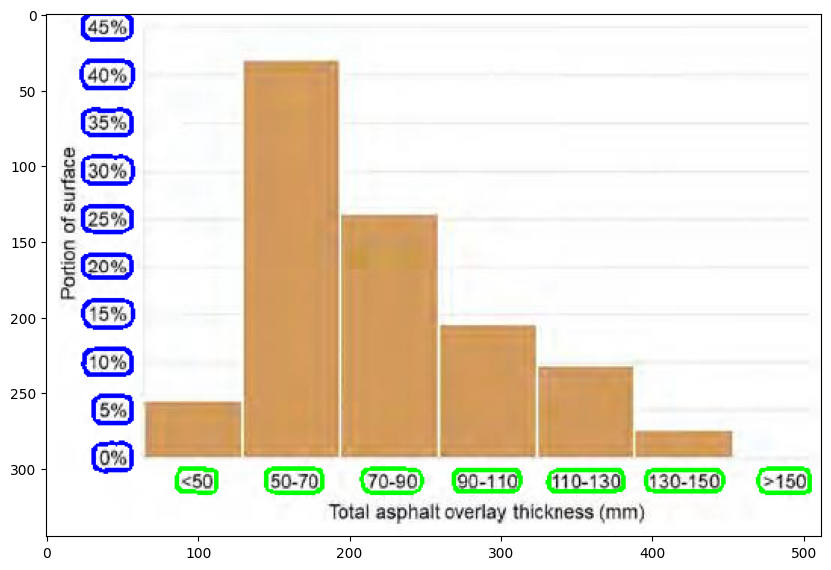

In [15]:
# visualize keypoint detection results, data is boxes
idx = 557
# idx = (idx + 1) % len(image_paths)
image = cv2.imread(image_paths[idx])
x_labels_polygons = x_labels_predictions[idx][0][0]
y_labels_polygons = y_labels_predictions[idx][0][0]

x_labels_polygons = filter_x_polygons(
    x_labels_polygons,
    image.shape[0],
    image_paths[idx],
)

y_labels_polygons = filter_y_polygons(
    y_labels_polygons,
    image.shape[1],
    image
)

# visualize x_label_boxes
image = cv2.imread(image_paths[idx])
for polygon in x_labels_polygons:
    polygon = np.array(polygon)
    polygon = polygon.reshape(-1, 2)
    polygon = polygon.astype(np.int32)
    cv2.drawContours(image, [polygon], 0, (0, 255, 0), 2)

# visualize y_label_boxes
for polygon in y_labels_polygons:
    polygon = np.array(polygon)
    polygon = polygon.reshape(-1, 2)
    polygon = polygon.astype(np.int32)
    cv2.drawContours(image, [polygon], 0, (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.imshow(image)
print(idx, image_paths[idx])

[{'x': '<50', 'y': 5.5759, 'x_pixel': 101, 'y_pixel': 257.31424}, {'x': '50-70', 'y': 41.3584, 'x_pixel': 167, 'y_pixel': 31.30623999999998}, {'x': '70-90', 'y': 25.2088, 'x_pixel': 229, 'y_pixel': 132.70544}, {'x': '90-110', 'y': 13.6507, 'x_pixel': 293, 'y_pixel': 205.63551999999999}, {'x': '110-130', 'y': 9.3758, 'x_pixel': 356, 'y_pixel': 232.99488}, {'x': '130-150', 'y': 2.5676, 'x_pixel': 425, 'y_pixel': 276.08088}, {'x': '>150', 'y': 0.1399, 'x_pixel': 488, 'y_pixel': 291.13262}]


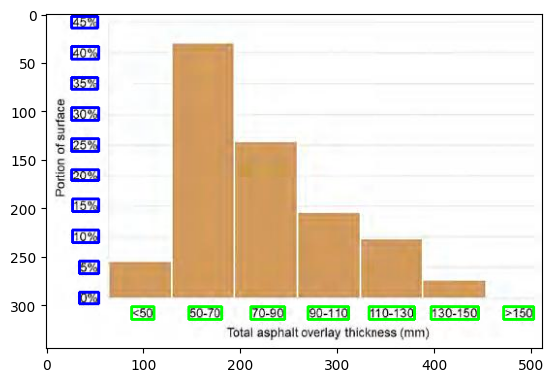

In [16]:
# visualize ground truth
image = cv2.imread(image_paths[idx])
for polygon in metadata_dict["images/" + image_paths[idx].split("/")[-1]]["ground_truth"]["gt_parse"]["y_labels_polygons"]:
    x0, y0, x1, y1, x2, y2, x3, y3 = polygon["x0"], polygon["y0"], polygon["x1"], polygon["y1"], polygon["x2"], polygon["y2"], polygon["x3"], polygon["y3"]
    polygon = np.array([[x0, y0], [x1, y1], [x2, y2], [x3, y3]])
    polygon = polygon.reshape(-1, 2)
    polygon = polygon.astype(np.int32)
    cv2.drawContours(image, [polygon], 0, (0, 0, 255), 2)

for polygon in metadata_dict["images/" + image_paths[idx].split("/")[-1]]["ground_truth"]["gt_parse"]["x_labels_polygons"]:
    x0, y0, x1, y1, x2, y2, x3, y3 = polygon["x0"], polygon["y0"], polygon["x1"], polygon["y1"], polygon["x2"], polygon["y2"], polygon["x3"], polygon["y3"]
    polygon = np.array([[x0, y0], [x1, y1], [x2, y2], [x3, y3]])
    polygon = polygon.reshape(-1, 2)
    polygon = polygon.astype(np.int32)
    cv2.drawContours(image, [polygon], 0, (0, 255, 0), 2)
plt.imshow(image)
print(metadata_dict["images/" + image_paths[idx].split("/")[-1]]["ground_truth"]["gt_parse"]["value"])

### Graph classification model, x/y labels classification model

In [17]:
graph_classes = ['dot', 'line', 'scatter', 'vertical_bar', "horizontal_bar"]

graph_type_predictions = graph_classification_model.predict(image_paths=image_paths)

# convert predictions to graph type
graph_type_predictions = np.argmax(graph_type_predictions, axis=1)
graph_type_predictions = [graph_classes[i] for i in graph_type_predictions]

100%|██████████| 35/35 [00:02<00:00, 12.75it/s]


In [18]:
gt_classes = []

for image_path in image_paths:
    gt_classes.append(metadata_dict["images/" + image_path.split("/")[-1]]["ground_truth"]["gt_parse"]["class"])

# calculate accuracy
acc = 0
for idx in range(len(image_paths)):
    if graph_type_predictions[idx] == gt_classes[idx]:
        acc += 1

print("acc: ", acc / len(image_paths))
print(np.unique(gt_classes, return_counts=True))

acc:  0.9874776386404294
(array(['horizontal_bar', 'line', 'scatter', 'vertical_bar'], dtype='<U14'), array([ 41, 204,  80, 234]))


In [19]:
type_classes = ["numerical", "categorical"]

x_type_predictions = x_type_classification_model.predict(image_paths=image_paths)
x_type_predictions = np.argmax(x_type_predictions, axis=1)
x_type_predictions = [type_classes[i] for i in x_type_predictions]

y_type_predictions = y_type_classification_model.predict(image_paths=image_paths)
y_type_predictions = np.argmax(y_type_predictions, axis=1)
y_type_predictions = [type_classes[i] for i in y_type_predictions]

100%|██████████| 35/35 [00:02<00:00, 12.88it/s]


In [20]:
x_type_gt_classes = []
y_type_gt_classes = []

for image_path in image_paths:
    x_type_gt_classes.append(metadata_dict["images/" + image_path.split("/")[-1]]["ground_truth"]["gt_parse"]["x_type"])
    y_type_gt_classes.append(metadata_dict["images/" + image_path.split("/")[-1]]["ground_truth"]["gt_parse"]["y_type"])

# calculate accuracy
x_type_acc = 0
y_type_acc = 0
for i in range(len(image_paths)):
    if x_type_predictions[i] == x_type_gt_classes[i]:
        x_type_acc += 1
    if y_type_predictions[i] == y_type_gt_classes[i]:
        y_type_acc += 1

print("x_type_acc: ", x_type_acc / len(image_paths))
print("y_type_acc: ", y_type_acc / len(image_paths))

x_type_acc:  0.9856887298747764
y_type_acc:  0.998211091234347


### Object detection model to detect point on graphs
1. Detect x_labels and y_labels points
2. Map these points with x_labels and y_labels texts
3. Post processing depends on the graph type

In [21]:
keypoint_predictions = keypoint_detection_model.predict(image_paths=image_paths)

2023-03-31 14:02:54.596 | INFO     | detection.src.tools.demo:inference:165 - Infer time: 0.0548s
2023-03-31 14:02:54.616 | INFO     | detection.src.tools.demo:inference:165 - Infer time: 0.0136s
2023-03-31 14:02:54.636 | INFO     | detection.src.tools.demo:inference:165 - Infer time: 0.0136s
2023-03-31 14:02:54.656 | INFO     | detection.src.tools.demo:inference:165 - Infer time: 0.0133s
2023-03-31 14:02:54.675 | INFO     | detection.src.tools.demo:inference:165 - Infer time: 0.0134s
2023-03-31 14:02:54.694 | INFO     | detection.src.tools.demo:inference:165 - Infer time: 0.0132s
2023-03-31 14:02:54.714 | INFO     | detection.src.tools.demo:inference:165 - Infer time: 0.0133s
2023-03-31 14:02:54.733 | INFO     | detection.src.tools.demo:inference:165 - Infer time: 0.0132s
2023-03-31 14:02:54.752 | INFO     | detection.src.tools.demo:inference:165 - Infer time: 0.0132s
2023-03-31 14:02:54.771 | INFO     | detection.src.tools.demo:inference:165 - Infer time: 0.0133s
2023-03-31 14:02:54.

In [22]:
def visualize(image_path, value_boxes, x_boxes, y_boxes, x_labels_polygons, y_labels_polygons):
    image = cv2.imread(image_path)

    if value_boxes is not None:
        for box in value_boxes:
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)

    if x_boxes is not None:
        for box in x_boxes:
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

    if y_boxes is not None:
        for box in y_boxes:
            cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)   
    
    if x_labels_polygons is not None:
        # visualize x_label_boxes
        for polygon in x_labels_polygons:
            polygon = np.array(polygon)
            polygon = polygon.reshape(-1, 2)
            polygon = polygon.astype(np.int32)
            cv2.drawContours(image, [polygon], 0, (255, 255, 0), 2)

    if y_labels_polygons is not None:
        # visualize y_label_boxes
        for polygon in y_labels_polygons:
            polygon = np.array(polygon)
            polygon = polygon.reshape(-1, 2)
            polygon = polygon.astype(np.int32)
            cv2.drawContours(image, [polygon], 0, (0, 255, 255), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)

-------- GROUND TRUTH ---------
graph type:  vertical_bar
{'x': '1889', 'y': 1.4015, 'x_pixel': 154, 'y_pixel': 377.9625}
{'x': '1899', 'y': 3.2934, 'x_pixel': 203, 'y_pixel': 330.665}
{'x': '1909', 'y': 5.5476, 'x_pixel': 252, 'y_pixel': 274.6969}
{'x': '1920', 'y': 10.2572, 'x_pixel': 301, 'y_pixel': 158.13430000000002}
{'x': '1930', 'y': 11.9478, 'x_pixel': 350, 'y_pixel': 116.29194999999999}
{'x': '1947', 'y': 11.1428, 'x_pixel': 400, 'y_pixel': 136.21570000000003}
{'x': '1960', 'y': 14.1618, 'x_pixel': 449, 'y_pixel': 60.95500000000001}
40 78b7a78e53c9.jpg


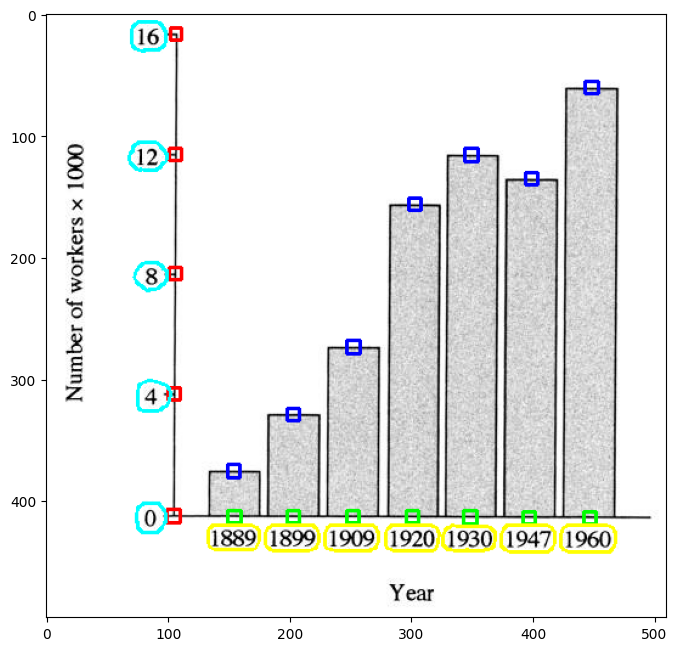

In [237]:
# ------------ SELECT ONE SAMPLE ------------
idx = 40
# idx = (idx - 1) % len(image_paths)
# while graph_type_predictions[idx] != "vertical_bar":
#     idx = (idx - 1) % len(image_paths)

data = keypoint_predictions[0][idx][0].cpu().numpy()

value_boxes = (data[data[:, 6] == 0][:, :4] / keypoint_predictions[1][idx]["ratio"]).astype(int)
x_boxes = (data[data[:, 6] == 1][:, :4] / keypoint_predictions[1][idx]["ratio"]).astype(int)
y_boxes = (data[data[:, 6] == 2][:, :4] / keypoint_predictions[1][idx]["ratio"]).astype(int)

x_labels_polygons = x_labels_predictions[idx][0][0]
y_labels_polygons = y_labels_predictions[idx][0][0]

# x_labels_polygons = filter_x_polygons(
#     x_labels_polygons,
#     image.shape[0],
#     image_paths[idx],
# )

y_labels_polygons = filter_y_polygons(
    y_labels_polygons,
    image.shape[1],
    image
)

visualize(image_paths[idx], value_boxes, x_boxes, y_boxes, x_labels_polygons, y_labels_polygons)

# ground truth
print("-------- GROUND TRUTH ---------")
print("graph type: ", metadata_dict["images/" + image_paths[idx].split("/")[-1]]["ground_truth"]["gt_parse"]["class"])
for v in metadata_dict["images/" + image_paths[idx].split("/")[-1]]["ground_truth"]["gt_parse"]["value"]:
    print(v)

print(idx, image_paths[idx].split("/")[-1])

pre filter:  7
post filter:  0


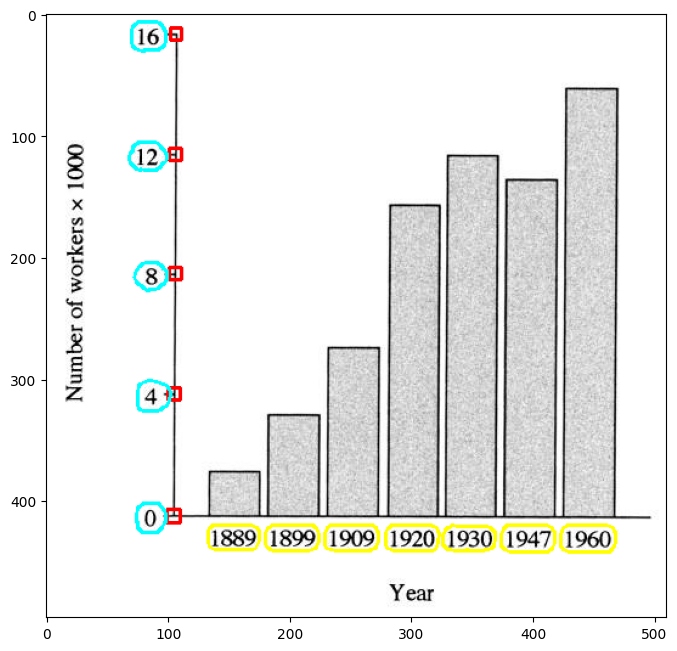

In [238]:
from copy import deepcopy

# GENERAL RULE:
# 1. Filter x_points, y_points by draw a line_y, line_x
def convert_4_points_box_to_polygon(box):
    x1, y1, x2, y2 = box
    return [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]

x_boxes_polygons = [convert_4_points_box_to_polygon(box) for box in x_boxes]

# TODO: check this function
print("pre filter: ", len(x_boxes_polygons))
x_boxes_polygons = filter_x_polygons(x_boxes_polygons, image.shape[0], image_paths[idx])
print("post filter: ", len(x_boxes_polygons))
x_boxes = [
    [
        min([p[0] for p in polygon]),
        min([p[1] for p in polygon]),
        max([p[0] for p in polygon]),
        max([p[1] for p in polygon]),
    ] 
    for polygon in x_boxes_polygons
]

y_boxes_polygons = [convert_4_points_box_to_polygon(box) for box in y_boxes]
y_boxes_polygons = filter_y_polygons(y_boxes_polygons, image.shape[1] // 2, image)
y_boxes = [
    [
        min([p[0] for p in polygon]),
        min([p[1] for p in polygon]),
        max([p[0] for p in polygon]),
        max([p[1] for p in polygon]),
    ]
    for polygon in y_boxes_polygons
]


# draw Ox, Oy of the graph based on centers of x_boxes and y_boxes
Oy = np.mean([(box[0] + box[2]) / 2 for box in y_boxes])
Ox = np.mean([(box[1] + box[3]) / 2 for box in x_boxes])
origin = (Ox, Oy)

# filter out those value_boxes that are not in the graph
filter_value_boxes = []
for box in value_boxes:
    x1, y1, x2, y2 = box
    if x2 > origin[1] and y1 < origin[0]:
        filter_value_boxes.append(box)

value_boxes = filter_value_boxes
# visualize x_boxes and y_boxes
visualize(image_paths[idx], value_boxes, x_boxes, y_boxes, x_labels_polygons, y_labels_polygons)

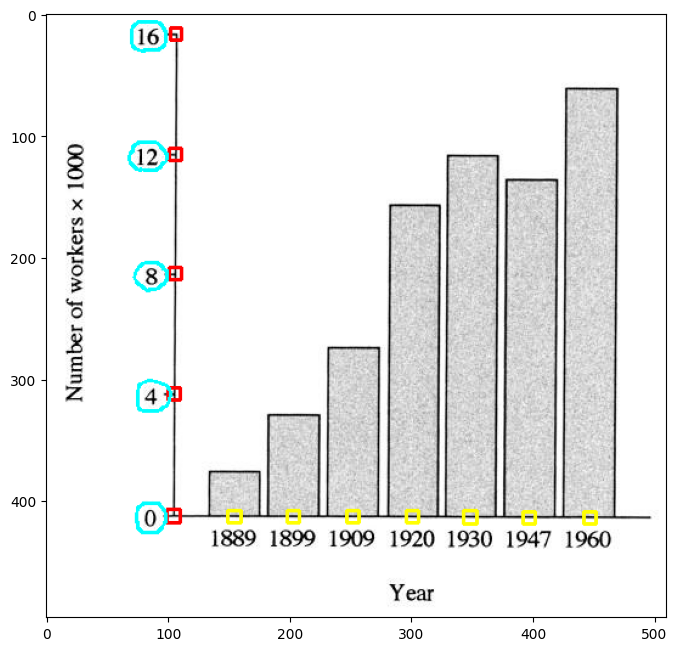

In [207]:
def compute_iou_and_distance_one_direction(polygon, box, direction="x"):
    x1, y1, x2, y2 = box
    polygon_min_x = min([p[0] for p in polygon])
    polygon_max_x = max([p[0] for p in polygon])
    polygon_min_y = min([p[1] for p in polygon])
    polygon_max_y = max([p[1] for p in polygon])


    if direction == "x":
        intersection = set(range(int(x1), int(x2))).intersection(set(range(int(polygon_min_x), int(polygon_max_x))))
        partly_union = set(range(int(x1), int(x2)))
        iou = len(intersection) / len(partly_union)
        distance = abs((y2 + y1) / 2 - (polygon_max_y + polygon_min_y) / 2)
        return iou, distance
    elif direction == "y":
        intersection = set(range(int(y1), int(y2))).intersection(set(range(int(polygon_min_y), int(polygon_max_y))))
        partly_union = set(range(int(y1), int(y2)))
        iou = len(intersection) / len(partly_union)
        distance = abs((x2 + x1) / 2 - (polygon_max_x + polygon_min_x) / 2)
        return iou, distance
    else:
        raise ValueError("direction must be x or y")

graph_type = graph_type_predictions[idx]

if graph_type == "horizontal_bar":
    # map x_labels with x_boxes because we don't need to be exact
    # map based on best iou in Ox direction
    # find all iou > o pairs between x_labels polygons and x_boxes
    pairs = []  # (x_labels_index, x_boxes_index, similarity)
    for i, x_label_polygon in enumerate(x_labels_polygons):
        for j, x_box in enumerate(x_boxes):
            iou, distance = compute_iou_and_distance_one_direction(x_label_polygon, x_box, direction="x")
            if iou > 0.2:
                pairs.append((i, j, iou, distance))
    
    # select only one pair for each y_label with the highest iou
    pairs = sorted(pairs, key=lambda x: (x[2], x[3]), reverse=True)
    
    filtered_pairs = []
    existed_indices = set()
    for pair in pairs:
        if pair[0] not in existed_indices:
            filtered_pairs.append(pair)
            existed_indices.add(pair[0])

    # get remaining y_labels_polygons and y_boxes
    remaining_x_labels_polygons = [x_labels_polygons[p[0]] for p in filtered_pairs]
    remaining_x_boxes = [x_boxes[p[1]] for p in filtered_pairs]

    x_labels_polygons = remaining_x_labels_polygons
    x_boxes = remaining_x_boxes
else:
    # map y_labels with y_boxes because we don't need to be exact
    # map based on best iou in Oy direction
    # find all iou > o pairs between y_labels polygons and y_boxes
    pairs = []  # (y_labels_index, y_boxes_index, similarity)
    for i, y_label_polygon in enumerate(y_labels_polygons):
        for j, y_box in enumerate(y_boxes):
            iou, distance = compute_iou_and_distance_one_direction(y_label_polygon, y_box, direction="y")
            if iou > 0.2:
                pairs.append((i, j, iou, distance))
    
    # select only one pair for each y_label with the highest iou
    pairs = sorted(pairs, key=lambda x: (x[2], x[3]), reverse=True)
    
    filtered_pairs = []
    existed_indices = set()
    for pair in pairs:
        if pair[0] not in existed_indices:
            filtered_pairs.append(pair)
            existed_indices.add(pair[0])

    # get remaining y_labels_polygons and y_boxes
    remaining_y_labels_polygons = [y_labels_polygons[p[0]] for p in filtered_pairs]
    remaining_y_boxes = [y_boxes[p[1]] for p in filtered_pairs]

    y_labels_polygons = remaining_y_labels_polygons
    y_boxes = remaining_y_boxes

# visualize x_boxes and y_boxes
visualize(image_paths[idx], value_boxes, x_boxes, y_boxes, x_labels_polygons, y_labels_polygons)

In [208]:
# ------------ VERTICAL BAR GRAPH -------------
# Data: x will always be categorical, y will always be numerical
# 1. we should prioritize value prediction, map 1-1 with x_points then if there is outlier x_points/values, ignore it, map with closest x2-x1 first, then y2-y1
# if number of x_labels is equal to number of x_boxes, then map 1-1
# if number of x_labels is different from number of x_boxes, then:
#     - get the rectangle of x_label
#     - draw a rhombus with the points is center of the rectangle edges
#     - draw a rectangle with the center be the highest point of the rhombus
#     - then map 1-1 with x_boxes

100%|██████████| 5/5 [00:00<00:00, 64.27it/s]
0it [00:00, ?it/s]


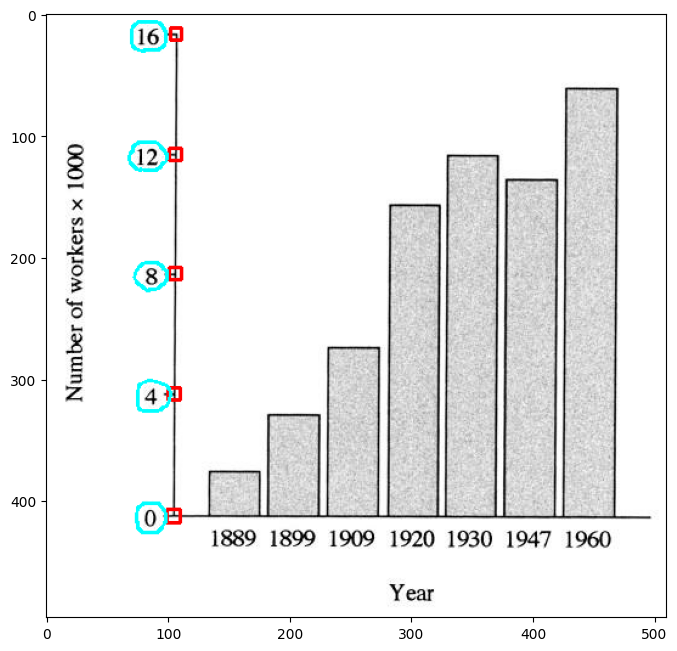

In [209]:
if graph_type_predictions[idx] == "vertical_bar":
    if len(x_labels_polygons) == len(x_boxes):
        # map 1-1
        indices_mapping = [(i, i) for i in range(len(x_labels_polygons))]
    else:
        # - get the min rectangle of x_label
        x_labels_boxes = []
        for x_label_polygon in x_labels_polygons:
            rect = cv2.minAreaRect(np.array(x_label_polygon))
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            x_labels_boxes.append(box)
        
        #     - draw a rhombus with the points is center of the rectangle edges
        x_labels_rhombuses = []
        for x_label_box in x_labels_boxes:
            x1, y1, x2, y2, x3, y3, x4, y4 = x_label_box.flatten()
            new_x1 = (x1 + x2) / 2
            new_y1 = (y1 + y2) / 2
            new_x2 = (x2 + x3) / 2
            new_y2 = (y2 + y3) / 2
            new_x3 = (x3 + x4) / 2
            new_y3 = (y3 + y4) / 2
            new_x4 = (x4 + x1) / 2
            new_y4 = (y4 + y1) / 2
            x_labels_rhombuses.append(np.array([[new_x1, new_y1], [new_x2, new_y2], [new_x3, new_y3], [new_x4, new_y4]]))

        #     - draw a rectangle with the center be the highest point of the rhombus
        x_labels_rectangles = []
        for x_label_rhombus in x_labels_rhombuses:
            # highest point is the point that has minimum y
            highest_point = None
            for point in x_label_rhombus:
                if highest_point is None:
                    highest_point = point
                else:
                    if point[1] < highest_point[1]:
                        highest_point = point
            x, y = highest_point
            w = 10
            h = 10 # x_boxes[0].shape[1]

            x1 = x - w
            y1 = y - h
            x2 = x1 + 2 * w
            y2 = y1 + 2 * h

            x_labels_rectangles.append(np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]]))

        # then map 1-1 with x_boxes
        pairs = []
        for i, x_label_rect in enumerate(x_labels_rectangles):
            for j, x_box in enumerate(x_boxes):
                iou, distance = compute_iou_and_distance_one_direction(x_label_rect, x_box, direction="x")
                if iou > 0.2:
                    pairs.append((i, j, iou, distance))
        
        # select only one pair for each y_label with the highest iou
        pairs = sorted(pairs, key=lambda x: (x[2], x[3]), reverse=True)
        
        filtered_pairs = []
        existed_labels_indices = set()
        existed_boxes_indices = set()
        for pair in pairs:
            if pair[0] not in existed_labels_indices and pair[1] not in existed_boxes_indices:
                filtered_pairs.append(pair)
                existed_labels_indices.add(pair[0])
                existed_boxes_indices.add(pair[1])


        indices_mapping = [(p[0], p[1]) for p in filtered_pairs]

        
    # get remaining y_labels_polygons and y_boxes
    remaining_x_labels_polygons = [x_labels_polygons[p[0]] for p in indices_mapping]
    remaining_x_boxes = [x_boxes[p[1]] for p in indices_mapping]

    x_labels_polygons = remaining_x_labels_polygons
    x_boxes = remaining_x_boxes
    
    # visualize(image_paths[idx], value_boxes, x_boxes, y_boxes, x_labels_polygons, y_labels_polygons)

    # map values
    value_indices_mapping = []
    if len(x_boxes) == len(value_boxes):
        value_indices_mapping = [(i, i) for i in range(len(value_boxes))]
    else:
        # rely on the number of x_boxes
        # map 1-1 with x_boxes, if there is any missing, set the value to minimum value of y_boxes value
        value_x_box_pairs = []
        for i, x_box in enumerate(x_boxes):
            for j, value_box in enumerate(value_boxes):
                # convert x_box to polygon
                x1, y1, x2, y2 = x_box
                x_box_polygon = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]])
                iou, distance = compute_iou_and_distance_one_direction(x_box_polygon, value_box, direction="x")
                if iou > 0.2:
                    value_x_box_pairs.append((i, j, iou, distance))
        
        value_x_box_pairs = sorted(value_x_box_pairs, key=lambda x: (x[2], x[3]), reverse=True)
        
        filtered_pairs = []
        existed_boxes_indices = set()
        existed_values_indices = set()
        for pair in value_x_box_pairs:
            if pair[0] not in existed_boxes_indices and pair[1] not in existed_values_indices:
                filtered_pairs.append(pair)
                existed_boxes_indices.add(pair[0])
                existed_values_indices.add(pair[1])

        value_indices_mapping = [(p[0], p[1]) for p in filtered_pairs]

    # add missing pairs with value_index -1 if missing value
    missing_x_indices = set(range(len(x_boxes))) - set([p[0] for p in value_indices_mapping])
    for missing_x_index in missing_x_indices:
        value_indices_mapping.append((missing_x_index, -1))
    
    inserted_value_boxes = []
    value_indices_mapping.sort(key=lambda x: x[0])
    for i, value_index in value_indices_mapping:
        if value_index != -1:
            inserted_value_boxes.append(value_boxes[value_index])
        else:
            inserted_value_boxes.append(x_boxes[i])

    value_boxes = inserted_value_boxes
    x_boxes = [x_boxes[p[0]] for p in value_indices_mapping]

    # visualize(image_paths[idx], value_boxes, x_boxes, y_boxes, x_labels_polygons, y_labels_polygons)

    # filter out those y boxes that are not numerical
    origin_image = cv2.imread(image_paths[idx])
    origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)

    crops = []
    for y_labels_polygon, y_box in zip(y_labels_polygons, y_boxes):
        crop = crop_polygon_from_image(origin_image, y_labels_polygon)
        crops.append(crop)
    
    filtered_texts, filtered_y_labels_polygons, filtered_y_boxes = [], [], []
    crops_texts = [p[0] for p in text_recognition_model.predict(crops)[0]]
    for text, y_labels_polygon, y_box in zip(crops_texts, y_labels_polygons, y_boxes):
        try: 
            t = text.replace(",", "").replace("%", "")
            if t.endswith("K") or t.endswith("k"):
                t = t[:-1]
            float(t)

            filtered_texts.append(text)
            filtered_y_labels_polygons.append(y_labels_polygon)
            filtered_y_boxes.append(y_box)
        except:
            print("Not numerical", text)

    pixel_value_pairs = []
    for i, y_box in enumerate(filtered_y_boxes):
        value_text = filtered_texts[i].replace(",", "").replace("%", "")
        if value_text.endswith("K") or value_text.endswith("k"):
            value_text = value_text.replace("K", "000")

        pixel_value_pairs.append(((y_box[1] + y_box[3]) / 2,  float(value_text)))

    if len(pixel_value_pairs) == 0:
        print("No y_boxes found!!!")
        all_values = [0] * len(x_labels_polygons)
    else:
        min_value = min([p[1] for p in pixel_value_pairs])

        # print(pixel_value_pairs)
        # calculate the real value of value boxes based on Oy axis
        # sort value_boxes
        value_boxes = sorted(value_boxes, key=lambda x: x[0])
        all_values = []
        for value_box in value_boxes:
            value_y_pixel = (value_box[1] + value_box[3]) / 2

            # find 2 nearest pixel_value_pairs to value_y_pixel
            nearest_pixel_value_pairs = sorted(pixel_value_pairs, key=lambda x: abs(x[0] - value_y_pixel))[:2]
            y1_pixel, y1_value = nearest_pixel_value_pairs[0]
            y2_pixel, y2_value = nearest_pixel_value_pairs[1]

            # calculate the real value of value_box
            if value_y_pixel > y1_pixel: # below the y1_pixel
                value_box_value = y1_value - abs((y2_value - y1_value) / (y2_pixel - y1_pixel) * (value_y_pixel - y1_pixel))
            else:
                value_box_value = y1_value + abs((y2_value - y1_value) / (y2_pixel - y1_pixel) * (value_y_pixel - y1_pixel))

            # print("----------------")
            # print("y1_pixel =", y1_pixel, "y1_value =", y1_value)
            # print("y2_pixel =", y2_pixel, "y2_value =", y2_value)
            # print("value_y_pixel =", value_y_pixel, "value_box_value =", value_box_value)
            if value_box_value < 0:
                value_box_value = min_value
            all_values.append(value_box_value)

    # predict text for x_labels_polygons
    # sort x_labels_polygons based on min x of x_labels_polygons
    x_labels_polygons = sorted(x_labels_polygons, key=lambda x: min([p[0] for p in x]))

    crops = []
    for x_labels_polygon in x_labels_polygons:
        crop = crop_polygon_from_image(origin_image, x_labels_polygon)
        crops.append(crop)

    x_labels_texts = [p[0] for p in text_recognition_model.predict(crops)[0]]

    # for x_label_text, value in zip(x_labels_texts, all_values):
    #     print(x_label_text, value)

    visualize(image_paths[idx], value_boxes, x_boxes, filtered_y_boxes, x_labels_polygons, filtered_y_labels_polygons)

In [210]:
# compute metrics
gt_xs = []
gt_ys = []

for v in metadata_dict["images/" + image_paths[idx].split("/")[-1]]["ground_truth"]["gt_parse"]["value"]:
    gt_xs.append(str(v["x"]))
    gt_ys.append(v["y"])  

ground_truth = pd.DataFrame.from_dict({
    '0a0a0_x': (gt_xs, 'vertical_bar'),
    '0a0a0_y': (gt_ys, 'vertical_bar'),
}, orient='index', columns=['data_series', 'chart_type']).rename_axis('id')

pred_xs = []
pred_ys = []

for x_label_text, value in zip(x_labels_texts, all_values):
    pred_xs.append(str(x_label_text))
    pred_ys.append(value)

predictions = pd.DataFrame.from_dict({
    '0a0a0_x': (pred_xs, 'vertical_bar'),
    '0a0a0_y': (pred_ys, 'vertical_bar'),
}, orient='index', columns=['data_series', 'chart_type']).rename_axis('id')

benetech_score(ground_truth, predictions)


0.0

In [211]:
predictions

,data_series,chart_type
id,,
0a0a0_x,[],vertical_bar
0a0a0_y,[],vertical_bar


In [212]:
ground_truth

,data_series,chart_type
id,,
0a0a0_x,"[1889, 1899, 1909, 1920, 1930, 1947, 1960]",vertical_bar
0a0a0_y,"[1.4015, 3.2934, 5.5476, 10.2572, 11.9478, 11....",vertical_bar


In [ ]:
# ------------ HORIZONTAL BAR GRAPH ------------
# Data: x will always be numerical, y will always be categorical

# ------------ SCATTER PLOT ------------
# Data: x will always be numerical, y will always be numerical
# 1. use value prediction

# ------------ LINE GRAPH ------------
# Data: x will always be categorical, y will always be numerical
# for the line graph, only keep prediction that is on the line, if number of predictions is equal to number of x_points, then keep all the predictions, else, map to the line to get data
# only predict for those x_labels that is on the line plot down to Ox

# ------------ DOT PLOT ------------


### Line chart postprocessing

In [ ]:
# # find the line in line chart using opencv
# def find_line(image):
#     # convert to grayscale
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#     lower = np.array([0, 0, 0])
#     upper = np.array([180, 255, 120])
#     mask = cv2.inRange(image, lower, upper)

#     mask = cv2.erode(mask, np.ones((1, 1), np.uint8), iterations=1)
#     mask = cv2.dilate(mask, np.ones((3, 3), np.uint8), iterations=1)
#     return mask

# mask = find_line(image)
# plt.imshow(mask)